# Lensing cross kSZ effect signal in Modified Gravity models

This notebook serves as a tutorial on how we compute the signal to noise ratio of the cross-correlation between the weak lensing convergence field and the kinetic Sunyaev-Zeldovich (kSZ) effect, in models beyond the scope of $\Lambda$CDM.

This cross-correlation is only non-zero due to the gravitomagnetic contribution to the weak-lensing convergence field, hence we regard this as a probe for the gravitomagnetic field B, i.e. the vector modes of the spacetime metric.

---

The relevant equations are:

\begin{equation}
C^{XY}_\ell=\frac{1}{2}\int{\rm d}\chi\chi^{-2}K_X(\chi)K_{Y}(\chi)P_{q_\perp}\left(k=\frac{\ell}{\chi},z(\chi)\right),
\end{equation}

where 
\begin{align}
    K_{\kappa_{\bf B}}(\chi) &= \frac{3}{2}H_0^2\Omega_ma^{-1}\int_0^{\chi}{\rm d}\chi'\frac{\chi'(\chi-\chi')}{\chi}\frac{{\rm d}\chi'}{{\rm d}z}p\left(z(\chi')\right),\\
    K_b(\chi) &= \frac{\sigma_{\rm T}\bar{n}_{e,0}}{c}a(\chi)^{-2}e^{-\tau},
\end{align}
are the kernels for the gravitomagnetic lensing convergence and kSZ effect, respectively.

Notice that the $C_\ell$ calculation is further simplified due to the simple choice of $p(z(\chi'))=\delta^{{\rm D}}(\chi'-\chi_s)$. Hence the lensing kernel becomes
\begin{align}
 K_{\kappa_{\bf B}}(\chi) &= \frac{3}{2}H_0^2\Omega_ma^{-1}\int_0^{\chi}{\rm d}\chi'\frac{\chi'(\chi-\chi')}{\chi}\frac{{\rm d}\chi'}{{\rm d}z}p\left(z(\chi')\right),\\
                          &= \frac{3}{2}H_0^2\Omega_ma^{-1}\frac{\chi_s(\chi-\chi_s)}{\chi}H^{-1}(\chi_s)
\end{align}

---

\begin{equation}
    C_{ij}^{XY}(\ell) = c\int_{z_\text{min}}^{z_\text{max}}dz\frac{W_i^X(z)W_j^Y(z)}{H(z)r^2(z)}P_{\delta\delta}(k_\ell,z)
\end{equation}

For compiling Pylians in a mac:

`set -x CC (brew --prefix llvm)/bin/clang

set -x CXX (brew --prefix llvm)/bin/clang++

set -x CPPFLAGS "-I"(brew --prefix llvm)"/include -I"(brew --prefix libomp)"/include"

set -x LDFLAGS "-L"(brew --prefix llvm)"/lib -L"(brew --prefix libomp)"/lib"
`


In [1]:
# Import some libraries
import numpy as np

from scipy.integrate import quad, simpson
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import scienceplots

from classy import Class

import plotting_library as PL
from pylab import *
import MAS_library as MASL
import Pk_library as PKL

import vp_utils as utils

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    # Figure
    'figure.figsize': (6.8, 4.2),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,

    # Lines and markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Font
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,

    # Axes
    'axes.linewidth': 1.0,
    'axes.grid': False,
    'grid.alpha': 0.3,

    # Ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,

    # Legend
    'legend.frameon': False,

    # Text rendering (LaTeX)
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',
    
})

In [2]:
parameters_sim = utils.parameters_sim

## Computing the power spectrum of the divergence-free component of a vector.

In general, for a rotational vector $u^i$, the power spectrum is defined via:

\begin{equation}
    \langle u^i(\vec{k})u^j(\vec{k'})\rangle = \delta^{(3)}(\vec{k}-\vec{k'}) (2\pi)^3 \frac{1}{2} \left(\delta^{ij}-\frac{k^ik^j}{k^2}\right)P_u(k)
\end{equation}

In particular, we are interested in the power spectrum of the curl of the momentum density field $\vec{q}\equiv(1+\delta)\vec{v}$, with $\vec{v}$ the velocity field. Let's call this quantity a vorticity density $\vec{\omega}=\nabla\times\vec{q}=\nabla\times[(1+\delta)\vec{v}]$ 

Some useful relations:
\begin{equation}
    k^4 P_B \sim P_{q\perp}\sim k^{-2}P_\omega.
\end{equation}

Recall that:
\begin{equation}
    \Delta(k) = \frac{k^3P(k)}{2\pi^2}
\end{equation}
We aim to compute $P_\omega$ and then transform it into any useful power spectrum that we want.

---

The basic steps are:
1. Deposit particles in a grid, to have them as a field.
2. Visualize the fields, its always nice to do.
3. Use Pylians to compute the respective power spectrum.
4. Interpolate the power spectra obtained, so we can use it in the next section.

### Building the fields

In [2]:
# # Load data and save it as .npy files

# nparts = 0
# for i in range(8):
#     with h5py.File(f"snapdir_000/snap_000.{i}.hdf5", "r") as f:
#         nparts += f['PartType1']['Coordinates'].shape[0]

# print("Total DM particles:", nparts)

# # Allocate big arrays up front
# pos = np.empty((nparts, 3), dtype=np.float32)
# vel = np.empty((nparts, 3), dtype=np.float32)

# # Second pass: fill them
# offset = 0
# for i in range(8):
#     with h5py.File(f"snapdir_000/snap_000.{i}.hdf5", "r") as f:
#         coords = f['PartType1']['Coordinates'][:]
#         vels = f['PartType1']['Velocities'][:]

#         n = coords.shape[0]
#         pos[offset:offset+n] = coords
#         vel[offset:offset+n] = vels
#         offset += n

# print("Final shapes:", pos.shape, vel.shape)

# # Optional: save to disk
# np.save("PartType1_Coordinates.npy", pos)
# np.save("PartType1_Velocities.npy", vel)

In [3]:
# def read_snap(N,snap,path):
#   """
#   Function given by Cristian's collaborator.
#   """
#   Lbox = 500. #L=1500 Mpc/h or 500 Mpc/h
#   pos_c = [None]*N

#   path = path+'/snapdir_%03d/'%snap

#   print("Data read from %s"%path)
  
#   infile = h5py.File(path+"snap_%03d.0.hdf5"%snap,"r")
#   print ('Redshift z=%1.2f'%infile["Header"].attrs["Redshift"])
  
#   for i in range(N):
#     f = h5py.File(path+"snap_%03d.%i.hdf5"%(snap,i),"r")
#     pos_c[i] = f["PartType1/IntegerCoordinates"][...]
#     f.close()

#   pos_c = np.concatenate(pos_c)
#   return pos_c/pow(2.0,32)*Lbox

# path_GR = os.getcwd()
# path1_a = path_GR
# posa_GR = read_snap(8,0,path1_a)

# np.save('Coordinates.npy', posa_GR)

In [4]:
# # Build the overdensity field (delta) using Pylians

# # density field parameters
# Ngrid    = 1024     #the 3D field will have grid x grid x grid voxels
# BoxSize = 500.0     #Mpc/h ; size of box
# MAS     = 'CIC'     #mass-assigment scheme
# verbose = True      #print information on progress

# # particle positions in 3D
# pos = np.load('outputs/Coordinates.npy').astype(np.float32)

# # define 3D density field
# delta_3d = np.zeros((Ngrid,Ngrid,Ngrid), dtype=np.float32)

# # construct 3D density field
# MASL.MA(pos, delta_3d, BoxSize, MAS, verbose=verbose)

# # at this point, delta contains the effective number of particles in each voxel
# # now compute overdensity and density constrast
# # save the density field as rho.npy
# np.save('outputs/rho.npy', delta_3d)
# delta_3d /= np.mean(delta_3d, dtype=np.float64)
# delta_3d -= 1.0

# np.save('outputs/delta_3d.npy', delta_3d)

In [5]:
# # Build momentum density field using Pylians

# BoxSize = 500.0
# Ngrid   = 1024
# MAS     = 'CIC'

# pos = np.load('outputs/Coordinates.npy').astype(np.float32)
# vel = np.load('outputs/Velocities.npy').astype(np.float32)

# rho = np.load('outputs/rho.npy')      
# print('data loaded')

# # qx = np.zeros_like(rho)
# # qy = np.zeros_like(rho)
# qz = np.zeros_like(rho)

# print('Computing vel fields...')

# MASL.MA(pos, qx, BoxSize, MAS, vel[:,0].astype(np.float32), True)
# qx /= np.mean(rho)
# np.save('outputs/Momentum_field_x.npy', qx)
# print('x saved')

# MASL.MA(pos, qy, BoxSize, MAS, vel[:,1].astype(np.float32), True)
# qy /= np.mean(rho)
# np.save('outputs/Momentum_field_y.npy', qy)
# print('y saved')

# MASL.MA(pos, qz, BoxSize, MAS, vel[:,2].astype(np.float32), True)
# qz /= np.mean(rho)
# np.save('outputs/Momentum_field_z.npy', qz)
# print('z saved')

In [6]:
# # Load previously computed fields
# delta_3d = np.load('outputs/delta_3d.npy')
# qx_field = np.load('outputs/Momentum_field_x.npy')
# qy_field = np.load('outputs/Momentum_field_y.npy')
# qz_field = np.load('outputs/Momentum_field_z.npy')

### Visualizing the fields

In [7]:
def plot_field(field, field_name, slice_idx=None, linthresh=1.0, cmap='hot', vmin=None, vmax=None):
    """
    Plot a 2D slice of a 3D cosmological field (density, overdensity, or momentum).

    Parameters
    ----------
    field : ndarray
        2D or 3D array to plot.
    field_name : str
        Name of the field: 'delta', 'density', 'q_x', 'q_y', 'q_z'
    slice_idx : int, optional
        Slice index along the 3rd axis if field is 3D. Default: middle slice.
    linthresh : float
        Linear threshold for SymLogNorm (delta and momentum fields).
    cmap : str
        Colormap to use.
    vmin, vmax : float, optional
        Color limits. If None, they will be determined automatically.
    """

    # Take middle slice if 3D
    if field.ndim == 3:
        if slice_idx is None:
            slice_idx = field.shape[2] // 2
        data = field[:, :, slice_idx].copy()
    else:
        data = field.copy()

    # Determine norm and label
    if field_name == 'density':
        data = data + 1
        label = r"$\rho/\bar{\rho}$"

    elif field_name == 'delta':
        label = r"$\delta$"

    elif field_name in ['q_x', 'q_y', 'q_z']:
        label = rf"${field_name}$"

    else:
        raise ValueError("field_name must be 'delta', 'density', 'q_x', 'q_y', or 'q_z'")

    # Plot
    norm = SymLogNorm(linthresh=linthresh,
                  vmin=vmin if vmin is not None else np.min(data),
                  vmax=vmax if vmax is not None else np.max(data))
    
    fig, ax = plt.subplots()
    cax = ax.imshow(data, cmap=cmap, norm=norm)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label(label, fontsize=14)
    ax.set_title(f"{field_name} field slice {slice_idx}")
    plt.show()

In [8]:
# plot_field(delta_3d, 'delta')
# plot_field(delta_3d, 'density')
# plot_field(qx_field, 'q_x')
# plot_field(qy_field, 'q_y')
# plot_field(qz_field, 'q_z')

### Computing the matter power spectrum

In [9]:
# # compute matter power spectrum using Pylians

# Pk = PKL.Pk(delta_3d, 500, 0, 'CIC', 1, True)

# # Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# # # 1D P(k)
# # k1D      = Pk.k1D
# # Pk1D     = Pk.Pk1D
# # Nmodes1D = Pk.Nmodes1D

# # # 2D P(k)
# # kpar     = Pk.kpar
# # kper     = Pk.kper
# # Pk2D     = Pk.Pk2D
# # Nmodes2D = Pk.Nmodes2D

# # 3D P(k)
# k       = Pk.k3D
# Pk0     = Pk.Pk[:,0] #monopole
# # Pk2     = Pk.Pk[:,1] #quadrupole
# # Pk4     = Pk.Pk[:,2] #hexadecapole
# # Pkphase = Pk.Pkphase #power spectrum of the phases
# # Nmodes  = Pk.Nmodes3D

# np.save('outputs/k_m.npy', k)
# np.save('outputs/Pk_m.npy', Pk0)

In [3]:
# Load matter power spectrum previously computed with Pylians
kh_m = np.load('outputs/k_m.npy')
Pkh_m = np.load('outputs/Pk_m.npy')

h = parameters_sim['h']

k_m = kh_m*h   # convert to 1/Mpc
Pk_m = Pkh_m/h**3  # convert to (Mpc)^3

In [4]:
CLASS = {}

# --- Cosmology parameters ---
params_base = {
    'output': 'tCl,sCl,lCl,mPk',
    'h': parameters_sim['h'],
    'Omega_cdm': parameters_sim['Omega_m'] - parameters_sim['Omega_b'],
    'Omega_b': parameters_sim['Omega_b'],
    'A_s': 2.1e-9,
    'n_s': 0.965,
    'tau_reio': 0.06,
    'modes': 's',
    'lensing': 'yes',
    'l_switch_limber': 50,
    'z_max_pk': 1080,
    'non_linear':'halofit',
    'P_k_max_1/Mpc' : '10'
    # 'selection': 'dirac',
    # 'selection_mean': '3.0',
}

# Constant z
params_const = params_base.copy()
params_const.update({'z_pk': '3.0'})

CLASS['const_z'] = Class()
CLASS['const_z'].set(params_const)
CLASS['const_z'].compute()

# Variable z
z_list = np.geomspace(0.01, 1080, 50)
params_var = params_base.copy()
params_var.update({'z_pk': ','.join([str(z) for z in z_list])})

CLASS['var_z'] = Class()
CLASS['var_z'].set(params_var)
CLASS['var_z'].compute()

# --- Define k grid (in 1/Mpc) ---
kk = np.geomspace(1e-4, 10., num=1000)

# --- Get P(k,z) at fixed z=3 ---
Pk_m_class_const_z = CLASS['const_z'].get_pk_all(kk, 3., nonlinear=True)

# --- Get P(k,z) at several z ---
z_list = [0, 0.1, 0.5, 1., 2., 3., 10., 100., 1080.]

Pk_m_class_varz = np.array([ CLASS['var_z'].get_pk_all(kk, z, nonlinear=True) for z in z_list])

Pk_m_class_varz_4interp = Pk_m_class_varz.T   # shape = (len(k_vals), len(z_list))

# --- Get lensing Cl from CLASS ---
# cl = CLASS['var_z'].lensed_cl()
cl_tot = CLASS['var_z'].raw_cl(2500)   # unlensed spectrum
cl_lensed = CLASS['var_z'].lensed_cl(2500)  # lensed spectrum

ells = cl_tot['ell']
Cl_pp_tot = cl_tot['pp']  # lensing potential power spectrum
Cl_kk_tot = .25 * (ells+2)*(ells+1)*ells*(ells-1) * Cl_pp_tot  # convergence spectrum

ells_lensed = cl_lensed['ell']
Cl_pp_lensed = cl_lensed['pp']  # lensing potential power spectrum
Cl_kk_lensed = .25 * (ells+2)*(ells+1)*ells*(ells-1) * Cl_pp_lensed  # convergence spectrum

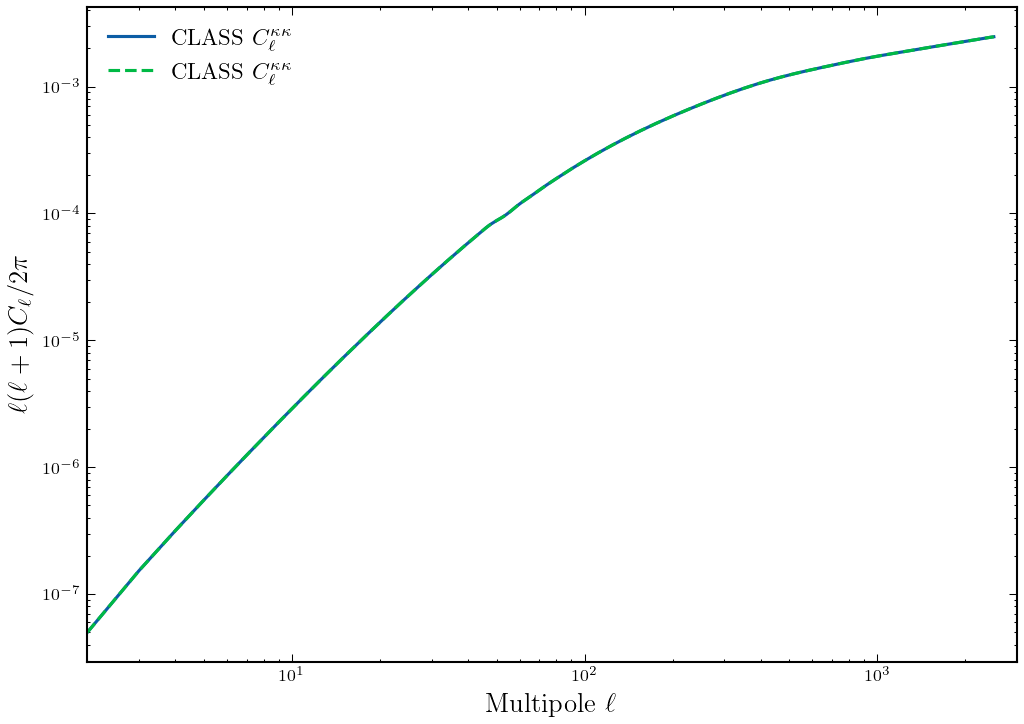

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))

factor = ells*(ells+1)/2/np.pi

ax.loglog(ells[2:], factor[2:]*Cl_kk_tot[2:], label=r"CLASS $C_\ell^{\kappa\kappa}$")
ax.loglog(ells[2:], factor[2:]*Cl_kk_lensed[2:], '--',label=r"CLASS $C_\ell^{\kappa\kappa}$")


ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell/2\pi$", fontsize=13)

ax.legend(fontsize=11, loc="best", frameon=False)
plt.xlim([2,3000])
plt.tight_layout()
plt.show()


In [6]:
### Interpolating power spectra:

from scipy.interpolate import RegularGridInterpolator, interp1d

Pk_m_class_constz_interp = interp1d(np.log(kk), np.log(Pk_m_class_const_z), kind='cubic')

def Pk_m_class_constz_int(k):
    return np.exp(Pk_m_class_constz_interp(np.log(k)))


# Build interpolator: axes are (z, k)
Pk_m_class_varz_interp = RegularGridInterpolator(
    (np.log(kk), z_list),   # grid coordinates
    np.log(Pk_m_class_varz_4interp),            # array with shape (len(z_list), len(k_vals))
    method='cubic',    # or "cubic" if you prefer smoother
    bounds_error=False,
    fill_value=None
)


def Pk_m_class_varz_int(x):
    k, z = x
    return np.exp(Pk_m_class_varz_interp((np.log(k), z)))

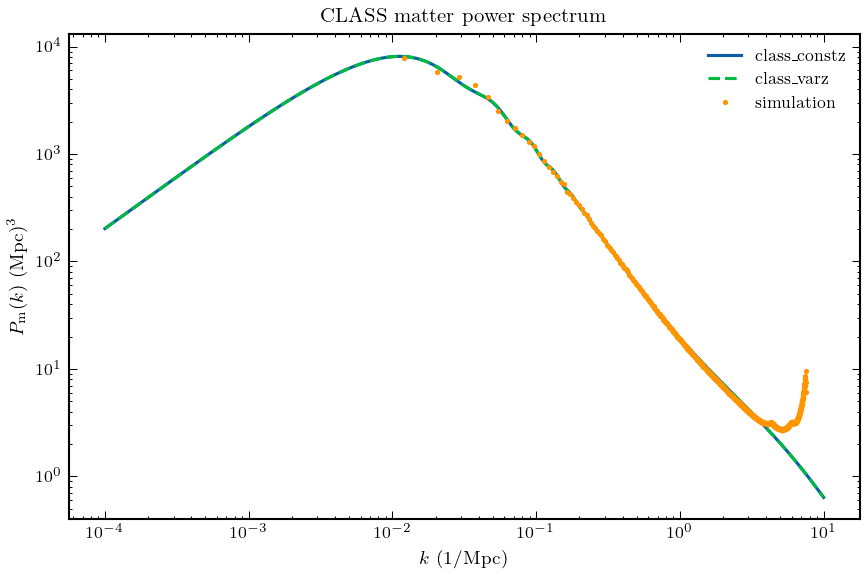

In [7]:
fig, ax = plt.subplots()

h_constz = CLASS['const_z'].h()
h_varz = CLASS['var_z'].h()

ax.loglog(kk, Pk_m_class_const_z, label='class_constz')
ax.loglog(kk, Pk_m_class_varz[-4], '--', label='class_varz')
ax.loglog(k_m, Pk_m, '.', label='simulation', ms=3)

ax.set_ylabel(r'$P_\text{m}(k)$ (Mpc)$^{3}$')
ax.set_xlabel(r'$k$ (1/Mpc)')
ax.set_title('CLASS matter power spectrum ')
ax.legend()

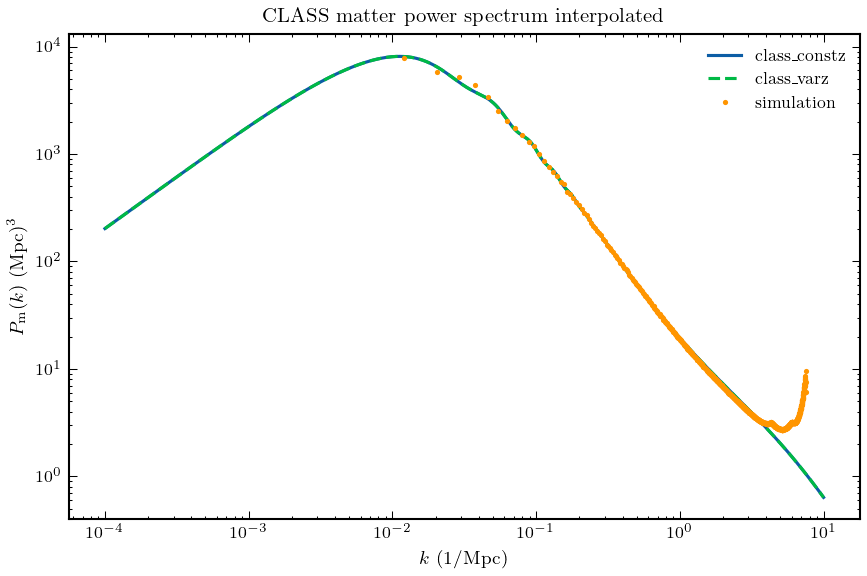

In [8]:
fig, ax = plt.subplots()

h_constz = CLASS['const_z'].h()
h_varz = CLASS['var_z'].h()

ax.loglog(kk, Pk_m_class_constz_int(kk), label='class_constz')
ax.loglog(kk, Pk_m_class_varz_int((kk,3)), '--', label='class_varz')
ax.loglog(k_m, Pk_m, '.', label='simulation', ms=3)

ax.set_ylabel(r'$P_\text{m}(k)$ (Mpc)$^{3}$')
ax.set_xlabel(r'$k$ (1/Mpc)')
ax.set_title('CLASS matter power spectrum interpolated')
ax.legend()

### Computing the power spectrum of the divergence-free component of a vector.


In [12]:
# # Compute curl power spectrum using Pylians

# k, Pk_curl, Nmodes = PKL.Pk_curl(qx_field, qy_field, qz_field, 1024, MAS='CIC', threads=1, cross_terms=True)

In [13]:
# np.save('outputs/k_curl.npy', k)
# np.save('outputs/Pk_curl.npy', Pk_curl)
# np.save('outputs/Nmodes_curl.npy', Nmodes)

In [9]:
# Load power spectrum previously computed 

kh_q = np.load('outputs/k_curl.npy')
Pkh_omega = np.load('outputs/Pk_curl.npy')
Nmodes_omega = np.load('outputs/Nmodes_curl.npy')

k_q = kh_q*h   # convert to 1/Mpc
Pk_omega = Pkh_omega/h**3  # convert to (Mpc)^3

Text(0, 0.5, '$\\Delta_\\text{B}(k)$')

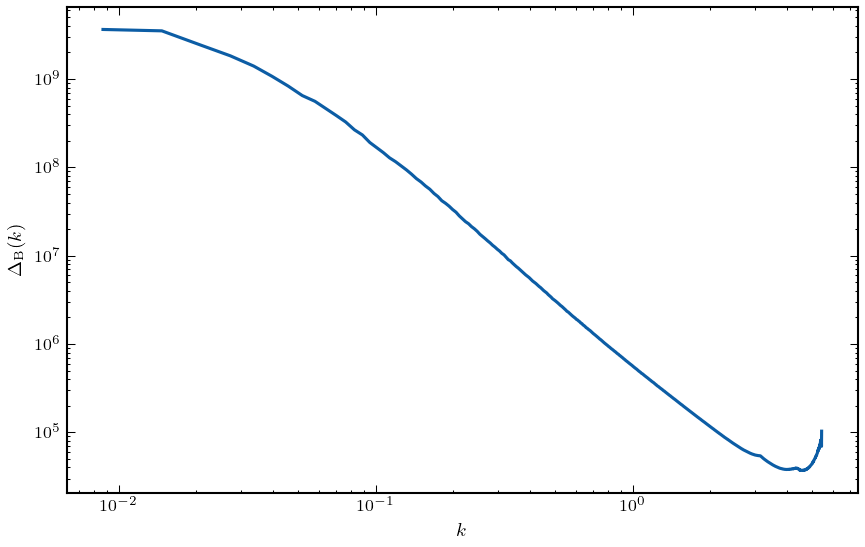

In [27]:
fig, ax = plt.subplots()

# ax.loglog(kh_q, Pk_omega/(kh_q**3)/(2*np.pi**2))
ax.loglog(kh_q, Pkh_omega/(kh_q**3)/(2*np.pi**2))

# ax.loglog(k, Pk_curl/(k**3)/(2*np.pi**2))
ax.set_xlabel('$k$')
ax.set_ylabel(r'$\Delta_\text{B}(k)$')

### Interpolating power spectra from simulations

In [30]:
Pk_matter_int = interp1d(np.log(k_m), np.log(Pk_m), kind='cubic')
Pk_omega_int = interp1d(np.log(k_q), np.log(Pk_omega), kind='cubic')

def Pk_matter_interp(k):
    return np.exp(Pk_matter_int(np.log(k)))

def Pk_momentum_interp(k):
    return np.exp(Pk_omega_int(np.log(k)))/k**2

## Computing $C_\ell$ for the cross correlation

In [31]:
ell_grid = np.arange(int(1e2), int(1e4))

C_ells_XY = {}

C_ells_XY['Phi'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['kSZ'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['B'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['B_X_kSZ'] = np.zeros_like(ell_grid, dtype=float)

for idx, ell in enumerate(ell_grid):


    C_ells_XY['Phi'][idx] = utils.C_ell_XY(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_matter_interp,
        type_XY='Phi',
        Pk_evol=True,
    )

    C_ells_XY['kSZ'][idx] = utils.C_ell_XY(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_matter_interp,
        type_XY='kSZ',
        Pk_evol=True,
    )

    C_ells_XY['B'][idx] = utils.C_ell_XY(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_momentum_interp,
        type_XY='B',
        Pk_evol=True,
    )

    C_ells_XY['B_X_kSZ'][idx] = utils.C_ell_XY(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_momentum_interp,
        type_XY='B_X_kSZ',
        Pk_evol=True,
    )


ValueError: A value (-6.096989559967425) in x_new is below the interpolation range's minimum value (-4.423567505343967).

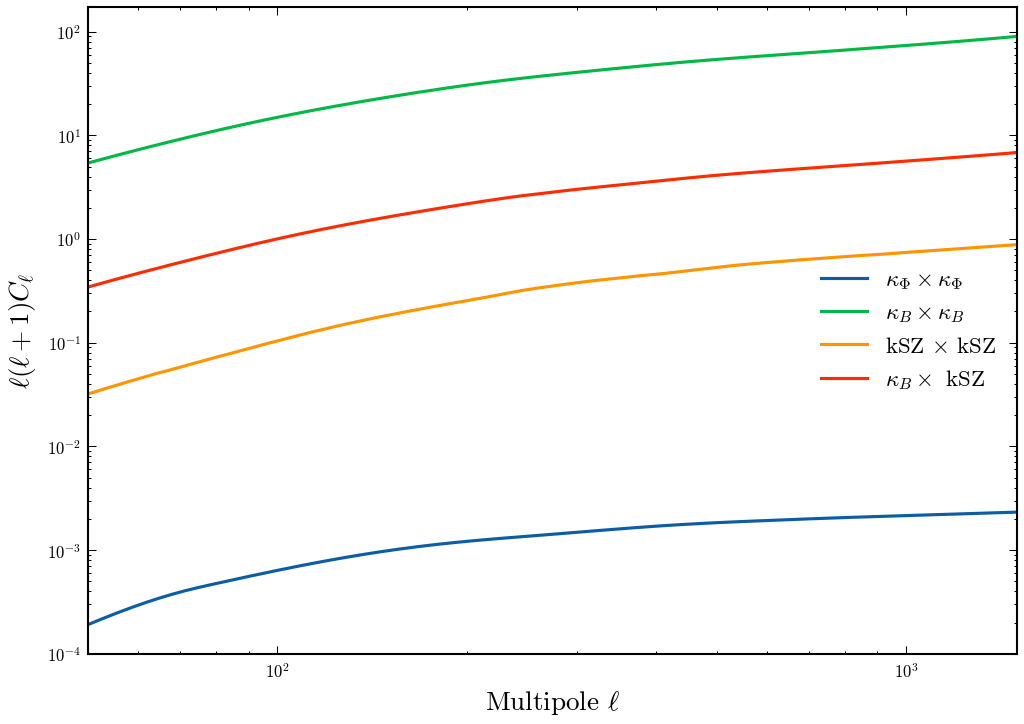

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['lensing']/1e9     , label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['gravB']       , label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['kSZ']         , label=r"kSZ $\times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['B_X_kSZ']     , label=r"$\kappa_B \times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


NameError: name 'C_ells' is not defined

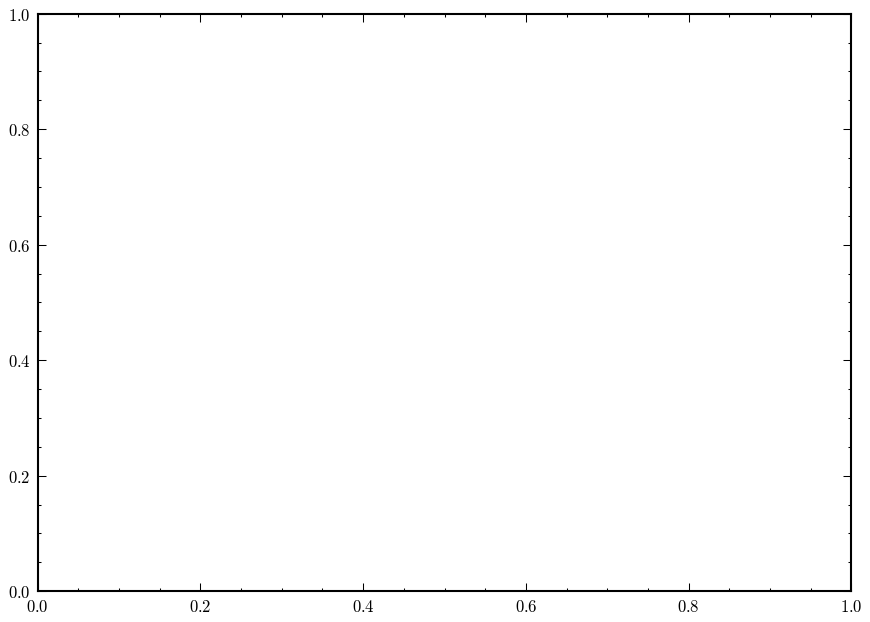

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

factor = Cl_kk[ell_grid[-1]]/C_ells['lensing'][-1]
factor_class = Cl_kk[ell_grid[-1]]/C_ells['lensing_class'][-1]

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['lensing'], label=r"Manual and const z")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['lensing_class'], label=r"Hybrid and var z")
ax.loglog(cl['ell'], cl['ell']*(cl['ell']+1)*Cl_kk, label=r"CLASS")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


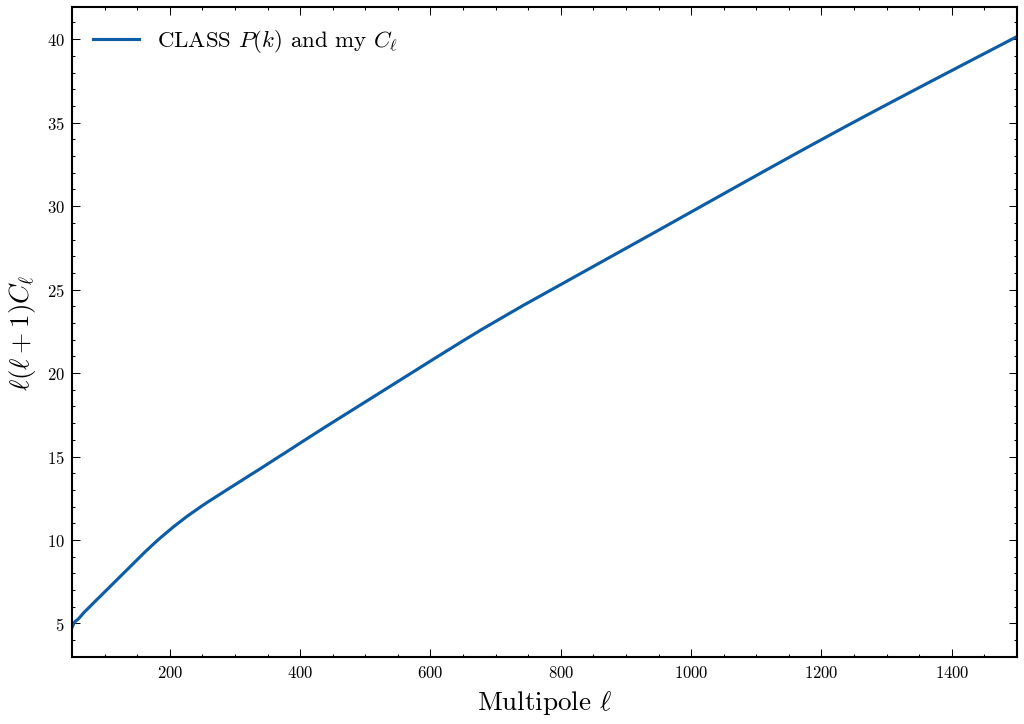

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

# factor = Cl_kk[ell_grid[-1]]/C_ells['lensing'][-1]
# factor_class = Cl_kk[ell_grid[-1]]/C_ells['lensing_class'][-1]

# Plot all spectra
ax.plot(ell_grid, ell_grid*C_ells_lensing/Cl_kk[ell_grid], label=r"CLASS $P(k)$ and my $C_\ell$")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


In [ ]:
cl['ell'][50]

50

In [ ]:
ell_grid

array([  50,   51,   52, ..., 1498, 1499, 1500])

In [ ]:
Cl_kk[ell_grid]

array([2.08620175e-07, 2.06123762e-07, 2.03778595e-07, ...,
       4.18334581e-09, 4.17783745e-09, 4.17233912e-09])

In [ ]:
chi_of_z(3)

array(4395.82414263)

In [ ]:
diff = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    diff[idx] = C_ells_lensing[idx]/Cl_kk[ell]

In [ ]:
cl['ell'][-1]

3000

In [ ]:
Cl_kk.shape

(3001,)

In [ ]:
diff

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
factor

4.052315432875813e-09

### Old Attempts

In [ ]:
def C_ell_XY(chi_s, ell, kmin, kmax, Pk, kernelX, kernelY, z_min=1e-5, Pk_evol=False):
    """
    Compute C_ell^{XY} for two arbitrary kernels X and Y.
    
    Parameters
    ----------
    chi_s : float
        Source comoving distance.
    ell : float
        Multipole moment.
    kmin, kmax : float
        Limits of k to restrict the chi integration range.
    Pk : function
        Power spectrum P(k) or P(k,z) depending on Pk_evol.
    kernelX, kernelY : function
        Kernel functions of the form kernel(chi, chi_s) or kernel(chi).
    chi_min : float
        Minimum chi integration limit.
    Pk_evol : bool
        If True, Pk takes two arguments: Pk(k,z).
    """
    z_s = z_of_chi(chi_s)
    z_grid = np.linspace(z_min, z_s, 1000)
    chi_grid = chi_of_z(z_grid)  # need chi(z) relation

    # restrict to valid chi by k range
    mask = (ell/chi_grid < kmax) & (ell/chi_grid > kmin)
    z_masked = z_grid[mask]
    r = chi_grid[mask]
    
    if Pk_evol:
        C_ell_int = Pk(ell/r, z_masked) / r**2
    else:
        C_ell_int = Pk(ell/r) / r**2
    
    # multiply by kernels (handle signature difference)
    try:
        KX = kernelX(r, chi_s)
    except TypeError:
        KX = kernelX(r)
    try:
        KY = kernelY(r, chi_s)
    except TypeError:
        KY = kernelY(r)

    C_ell_int *= KX * KY
    
    # geometric prefactor you had
    C_ell_int *= sol / Hubble(z_masked)
    
    # integrate
    C_ell = simpson(C_ell_int, x=z_masked)
    
    return C_ell

In [ ]:
Pk_matter_int = interp1d(k_m, Pk_m, kind='quadratic')
Pk_matter_class_int = interp1d(k_vals, Pk_m_class, kind='quadratic')

Pk_omega_int = interp1d(k_q, Pk_omega, kind='quadratic')

Text(0, 0.5, '$P_\\text{q\\perp}(k)$')

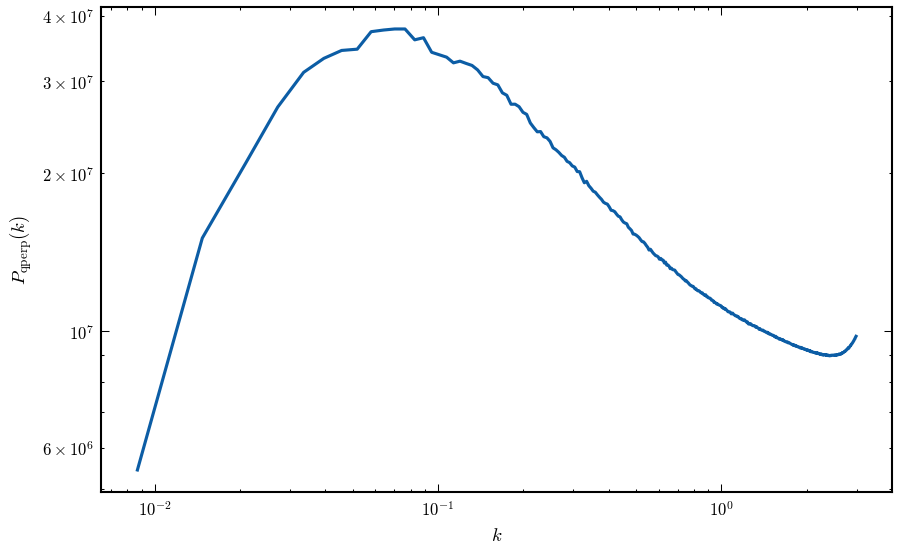

In [ ]:
idx_k = 400

fig, ax = plt.subplots()

ax.loglog(k_q[:-idx_k], Pk_omega_int(k_q[:-idx_k])/(k_q[:-idx_k]))
ax.set_xlabel('$k$')
ax.set_ylabel(r'$P_\text{q\perp}(k)$')

In [ ]:
ell_grid = np.arange(100,1001)

C_ells_ = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells_WL[idx] = C_ell_XY(chi_of_z(3), ell, k_q[0], k_q[-1], Pk_omega_int, kernel_kappaB, kernel_kappaB)

In [ ]:
ell_grid = np.arange(100,10001)

C_ells = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells[idx] = C_ell_ksz_kappaB(chi_of_z(3), ell, k_q[0], k_q[-401], Pk_omega_int)

In [ ]:
ell_grid = np.arange(100,1001)

C_ells_WL = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells_WL[idx] = C_ell_WL(chi_of_z(3), ell, k_vals[0], k_vals[-1], Pk_matter_class_int)

NameError: name 'C_ell_WL' is not defined

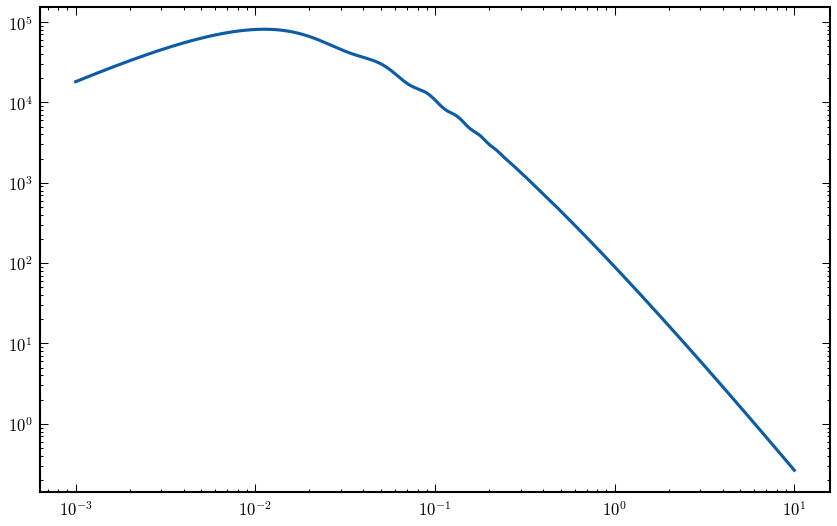

In [ ]:
fig, ax =plt.subplots()

ax.loglog(k_vals, Pk_matter_class_int(k_vals))

In [ ]:
k_vals[0], k_vals[-1]

(0.001, 10.0)

Text(0, 0.5, '$C_\\ell^{\\kappa_B kSZ}$')

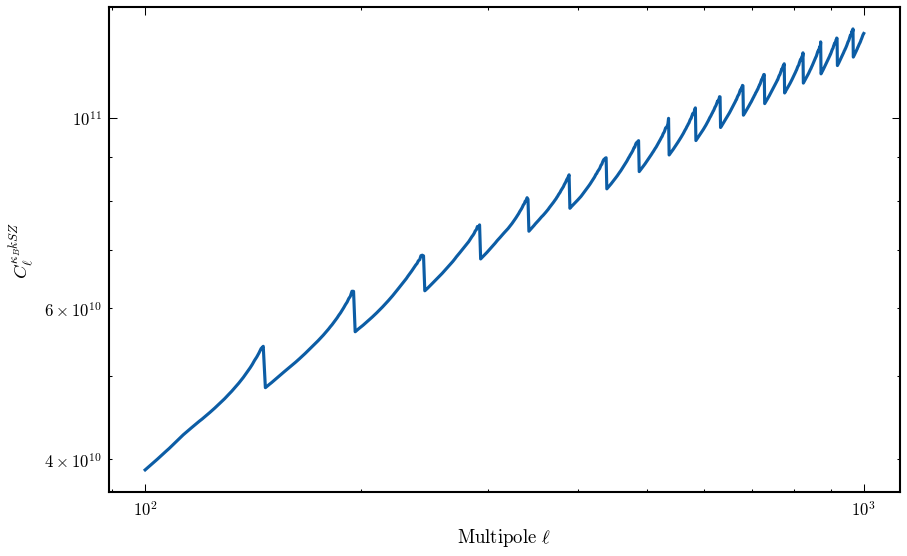

In [ ]:
idxfig, ax = plt.subplots()

ax.loglog(ell_grid, C_ells_WL)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('$C_\ell^{\kappa_B kSZ}$')

Text(0, 0.5, '$C_\\ell^{\\kappa_B kSZ}$')

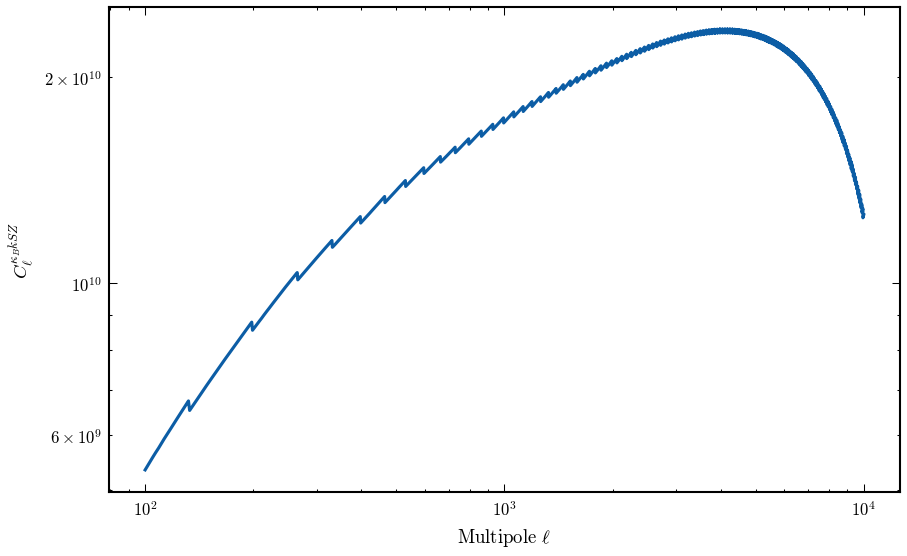

In [ ]:
fig, ax = plt.subplots()

ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('$C_\ell^{\kappa_B kSZ}$')

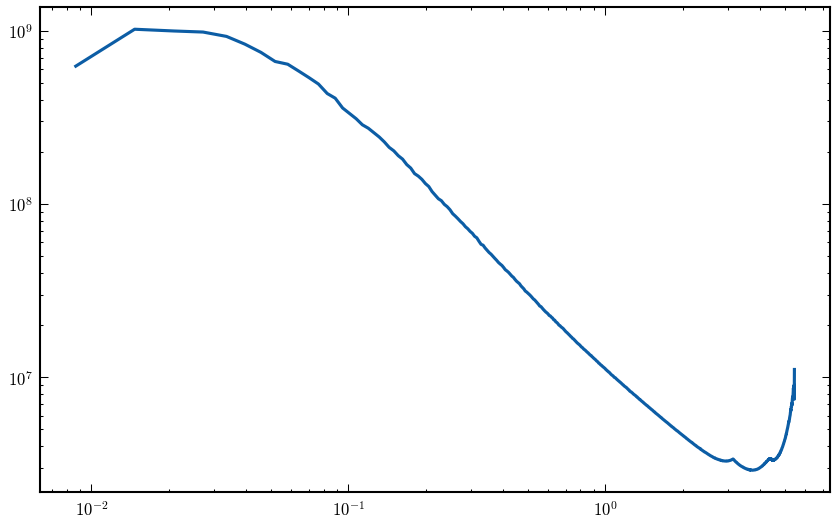

In [ ]:
plt.loglog(k_q, Pk_omega_int(k_q)/(k_q**2))

In [ ]:
C_ell, chis = C_ell_ksz_kappaB(3, 10, k_q[0], k_q[-401], Pk_omega_int)

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
ell_grid = np.arange(100,1001)

C_ells = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells[idx] = C_ell_ksz_kappaB(chi_of_z(3), ell, k_q[0], k_q[-1], Pk_omega_int)[0]

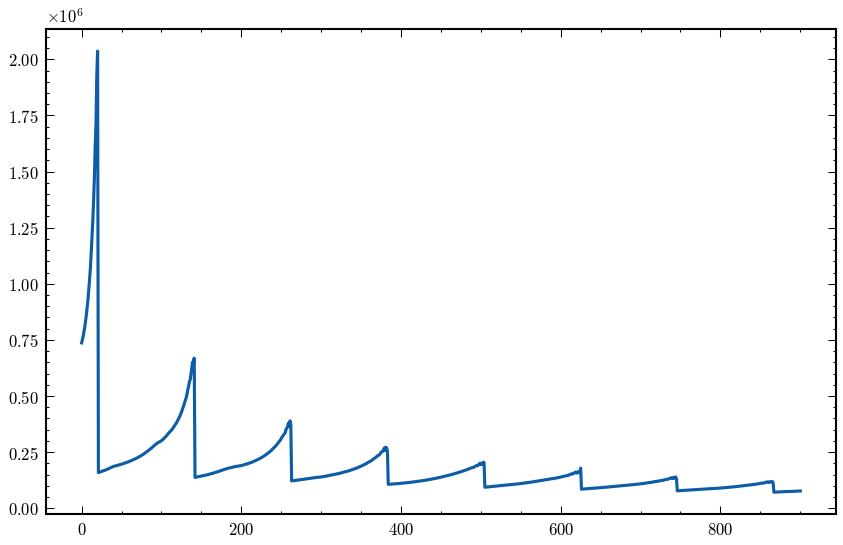

In [ ]:
plt.plot(C_ells)

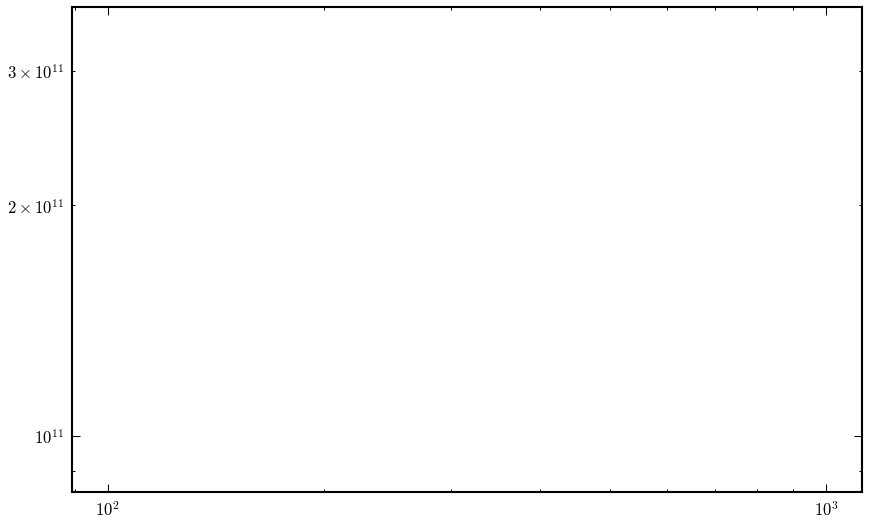

In [ ]:
ell_grid = np.arange(100,1001)

fig, ax = plt.subplots()

for idx, ell in enumerate(ell_grid):
    ax.loglog(ell, ell*(1+ell)*C_ell_ksz_kappaB(chi_of_z(3), ell, k_q[0], k_q[-1], Pk_omega_int))

---
CHATGPT
---


In [ ]:
z_table = np.linspace(0, 3, 2000)
chi_table = np.zeros_like(z_table)

pars = parameters_sim
for i, zz in enumerate(z_table):
    z_grid = np.linspace(0, zz, 1000)
    integrand = 1 / Hubble(z_grid, pars=parameters_sim)
    chi_table[i] = simpson(integrand, x=z_grid) * pars['c'] * pars['h']

chi_interp = interp1d(z_table, chi_table, kind="cubic", fill_value="extrapolate")

def chi_of_z(z):
    return chi_interp(z)

In [ ]:
def kernel_kappaB(z, z_s):
    """ Lensing convergence kernel for sources at z_s. """
    chi = chi_of_z(z)
    chi_s = chi_of_z(z_s)
    prefactor = 1.5 * pars['H0']**2 * pars['Omega_m'] / pars['c']**2
    output = prefactor * (1+z) * chi * (chi_s - chi) / chi_s
    return output * (z < z_s)  # enforce chi < chi_s


def kernel_ksz(z, z_s=None):
    """ kSZ kernel (independent of z_s). """
    a = a_of_z(z)
    chi = chi_of_z(z)
    output = (
        pars['SigmaT'] * 3.086e22 / pars['h'] *
        n_ele(z_of_a(a)) * a *
        np.exp(-tau_optical_depth(z))
    )
    return output


def kernel_kappaPhi(z, z_s):
    """ Phi-kappa cross kernel, proportional to kappaB. """
    return 0.5 * pars['c'] * kernel_kappaB(z, z_s)

In [ ]:
def C_ell_XY(z_s, ell, kmin, kmax, Pk, kernelX, kernelY, z_min=1e-5, Pk_evol=False, pars=parameters_sim):
    """
    Compute C_ell^{XY} integrating over redshift.
    Kernels must have signature kernel(z, z_s).
    """
    z_grid = np.linspace(z_min, z_s, 1000)
    chi_grid = chi_of_z(z_grid)

    # restrict to valid chi by k-range
    mask = (ell/chi_grid < kmax) & (ell/chi_grid > kmin)
    z = z_grid[mask]
    chi = chi_grid[mask]
    if z.size == 0:  # safety check
        return 0.0

    if Pk_evol:
        C_ell_int = Pk(ell/chi, z) / chi**2
    else:
        C_ell_int = Pk(ell/chi) / chi**2
    
    # kernels
    KX = kernelX(z, z_s)
    KY = kernelY(z, z_s)
    C_ell_int *= KX * KY
    
    # factor dchi/dz
    C_ell_int *= pars['c'] / Hubble(z, pars)
    
    # integrate in z
    C_ell = simpson(C_ell_int, x=z)
    return C_ell

In [ ]:
ell_grid = np.arange(100, 1001)
C_ells_gravB = np.zeros_like(ell_grid, dtype=float)
C_ells_lens = np.zeros_like(ell_grid, dtype=float)
C_ells_ksz = np.zeros_like(ell_grid, dtype=float)
C_ells_gravB_x_ksz = np.zeros_like(ell_grid, dtype=float)

for idx, ell in enumerate(ell_grid):
    C_ells_gravB[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_kappaB,
        kernelY=kernel_kappaB
    )
    C_ells_lens[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_m[0],
        kmax=k_m[-1],
        Pk=Pk_matter_int,
        kernelX=kernel_kappaPhi,
        kernelY=kernel_kappaPhi
    )
    C_ells_ksz[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_ksz,
        kernelY=kernel_ksz
    )
    C_ells_gravB_x_ksz[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_kappaB,
        kernelY=kernel_ksz
    )

Text(0, 0.5, '$C_\\ell^{\\kappa_B kSZ}$')

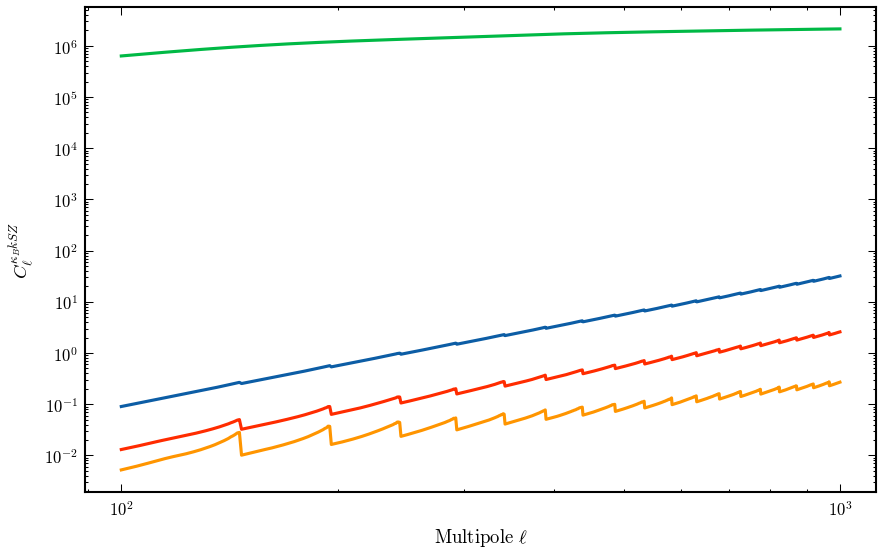

In [ ]:
fig, ax = plt.subplots()

ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_gravB)
ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_lens)
ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_ksz)
ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_gravB_x_ksz)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('$C_\ell^{\kappa_B kSZ}$')

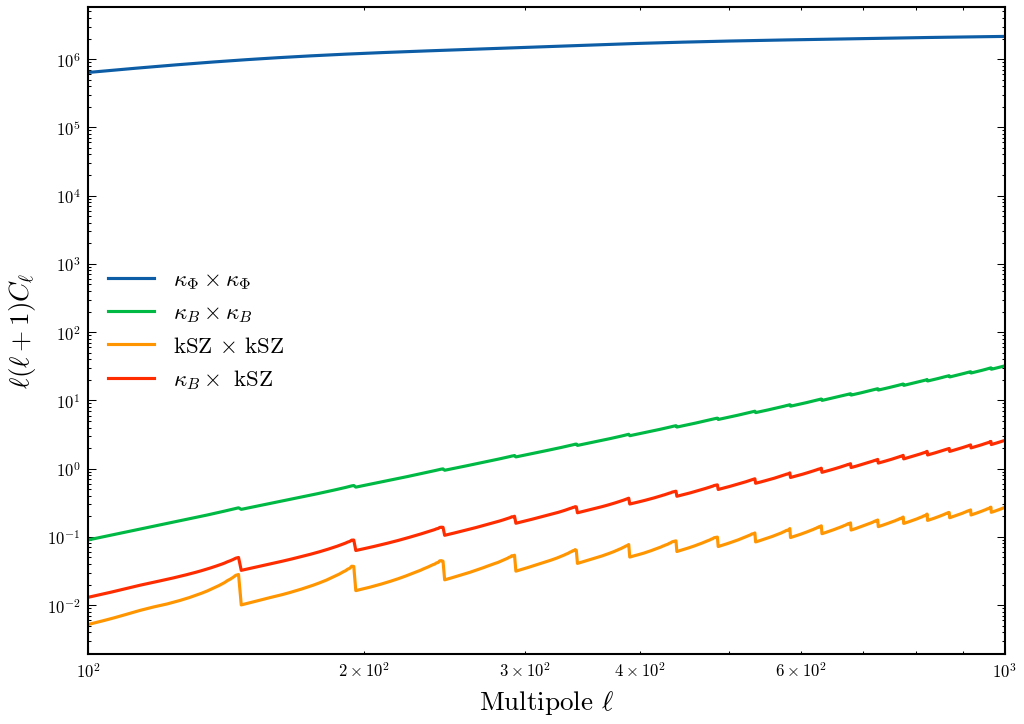

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_lens, label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_gravB, label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_ksz, label=r"kSZ $\times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_gravB_x_ksz, label=r"$\kappa_B \times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()
